# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [6]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [7]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        W1 -= eta*grad_W1
        W2 -= eta*grad_W2
        b1 -= eta*grad_b1
        b2 -= eta*grad_b2
        
    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305335 Accuracy 0.097714
Epoch 10 Loss 2.296672 Accuracy 0.097714
Epoch 20 Loss 2.287408 Accuracy 0.097714
Epoch 30 Loss 2.277089 Accuracy 0.103429
Epoch 40 Loss 2.265467 Accuracy 0.197143
Epoch 50 Loss 2.252390 Accuracy 0.293143
Epoch 60 Loss 2.237777 Accuracy 0.396857
Epoch 70 Loss 2.221640 Accuracy 0.476286
Epoch 80 Loss 2.204079 Accuracy 0.551429
Epoch 90 Loss 2.185240 Accuracy 0.609429
Epoch 100 Loss 2.165283 Accuracy 0.637714
Epoch 110 Loss 2.144374 Accuracy 0.648000
Epoch 120 Loss 2.122673 Accuracy 0.652000
Epoch 130 Loss 2.100327 Accuracy 0.655143
Epoch 140 Loss 2.077472 Accuracy 0.658000
Epoch 150 Loss 2.054227 Accuracy 0.659429
Epoch 160 Loss 2.030694 Accuracy 0.662000
Epoch 170 Loss 2.006978 Accuracy 0.661143
Epoch 180 Loss 1.983178 Accuracy 0.664571
Epoch 190 Loss 1.959366 Accuracy 0.666000
Epoch 200 Loss 1.935597 Accuracy 0.667143
Epoch 210 Loss 1.911922 Accuracy 0.669429
Epoch 220 Loss 1.888383 Accuracy 0.673143
Epoch 230 Loss 1.865015 Accuracy 0.677714
Epo

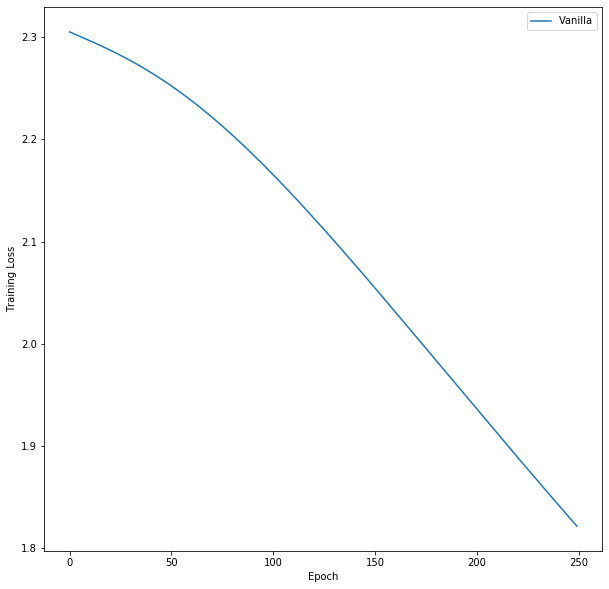

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [9]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-4
beta1 = 0.9

initial_batch_size = 104
epochs = 250

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

"""
You probably need to initialize your momentum here... 
"""

m_w1 = np.zeros(W1.shape)
m_w2 = np.zeros(W2.shape)
m_b1 = np.zeros(b1.shape)
m_b2 = np.zeros(b2.shape)

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

        # update momentum:
        m_w1 = beta1*m_w1 + (1-beta1)*grad_W1
        m_w2 = beta1*m_w2 + (1-beta1)*grad_W2
        m_b1 = beta1*m_b1 + (1-beta1)*grad_b1
        m_b2 = beta1*m_b2 + (1-beta1)*grad_b2
        
        W1 -= eta*m_w1
        W2 -= eta*m_w2
        b1 -= eta*m_b1
        b2 -= eta*m_b2
        
    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.298367 Accuracy 0.097714
Epoch 10 Loss 2.150751 Accuracy 0.645429
Epoch 20 Loss 1.919771 Accuracy 0.667714
Epoch 30 Loss 1.694334 Accuracy 0.708571
Epoch 40 Loss 1.498783 Accuracy 0.740571
Epoch 50 Loss 1.333757 Accuracy 0.781429
Epoch 60 Loss 1.195189 Accuracy 0.828286
Epoch 70 Loss 1.078796 Accuracy 0.854286
Epoch 80 Loss 0.980865 Accuracy 0.870571
Epoch 90 Loss 0.898157 Accuracy 0.884571
Epoch 100 Loss 0.827907 Accuracy 0.893714
Epoch 110 Loss 0.767823 Accuracy 0.896571
Epoch 120 Loss 0.716042 Accuracy 0.898857
Epoch 130 Loss 0.671069 Accuracy 0.903714
Epoch 140 Loss 0.631728 Accuracy 0.909429
Epoch 150 Loss 0.597086 Accuracy 0.910571
Epoch 160 Loss 0.566378 Accuracy 0.913714
Epoch 170 Loss 0.538985 Accuracy 0.915143
Epoch 180 Loss 0.514407 Accuracy 0.916571
Epoch 190 Loss 0.492234 Accuracy 0.917429
Epoch 200 Loss 0.472127 Accuracy 0.918000
Epoch 210 Loss 0.453808 Accuracy 0.918857
Epoch 220 Loss 0.437050 Accuracy 0.919714
Epoch 230 Loss 0.421661 Accuracy 0.920857
Epo

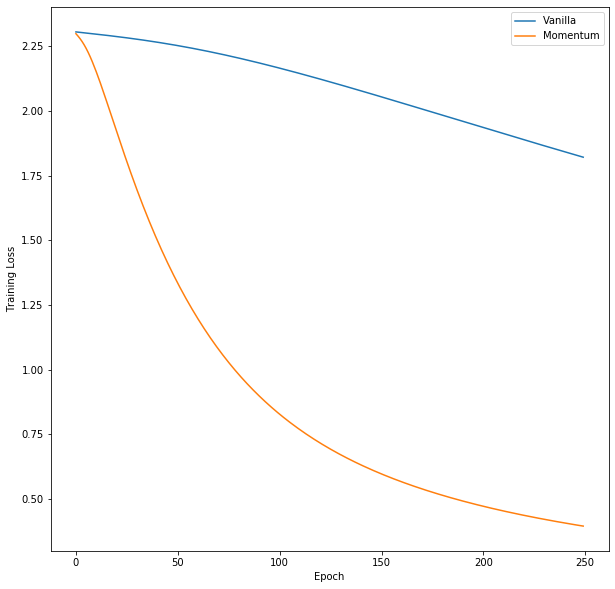

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [11]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""

beta2 = 0.99
epsilon = 0.00000000001

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""

v_w1 = np.zeros(W1.shape)
v_w2 = np.zeros(W2.shape)
v_b1 = np.zeros(b1.shape)
v_b2 = np.zeros(b2.shape)

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        
        # update variance
        v_w1 = beta2*v_w1 + (1-beta2)*np.square(W1)
        v_w2 = beta2*v_w2 + (1-beta2)*np.square(W2)
        v_b1 = beta2*v_b1 + (1-beta2)*np.square(b1)
        v_b2 = beta2*v_b2 + (1-beta2)*np.square(b2)

        # update params:
        W1 -= eta*np.divide(grad_W1, np.sqrt(v_w1 + epsilon) )
        W2 -= eta*np.divide(grad_W2, np.sqrt(v_w2 + epsilon) )
        b1 -= eta*np.divide(grad_b1, np.sqrt(v_b1 + epsilon) )
        b2 -= eta*np.divide(grad_b2, np.sqrt(v_b2 + epsilon) )
        
    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 1.509151 Accuracy 0.832286
Epoch 10 Loss 0.815150 Accuracy 0.903714
Epoch 20 Loss 0.614179 Accuracy 0.912857
Epoch 30 Loss 0.512658 Accuracy 0.915714
Epoch 40 Loss 0.448452 Accuracy 0.917143
Epoch 50 Loss 0.399460 Accuracy 0.917714
Epoch 60 Loss 0.363736 Accuracy 0.919143
Epoch 70 Loss 0.335967 Accuracy 0.920286
Epoch 80 Loss 0.313927 Accuracy 0.920571
Epoch 90 Loss 0.295888 Accuracy 0.920857
Epoch 100 Loss 0.280427 Accuracy 0.921714
Epoch 110 Loss 0.266433 Accuracy 0.922857
Epoch 120 Loss 0.254419 Accuracy 0.923143
Epoch 130 Loss 0.243663 Accuracy 0.923714
Epoch 140 Loss 0.234522 Accuracy 0.923429
Epoch 150 Loss 0.226115 Accuracy 0.924857
Epoch 160 Loss 0.218635 Accuracy 0.924857
Epoch 170 Loss 0.211957 Accuracy 0.925714
Epoch 180 Loss 0.205865 Accuracy 0.926000
Epoch 190 Loss 0.200406 Accuracy 0.926286
Epoch 200 Loss 0.195412 Accuracy 0.927143
Epoch 210 Loss 0.190680 Accuracy 0.926857
Epoch 220 Loss 0.186350 Accuracy 0.926857
Epoch 230 Loss 0.182260 Accuracy 0.926286
Epo

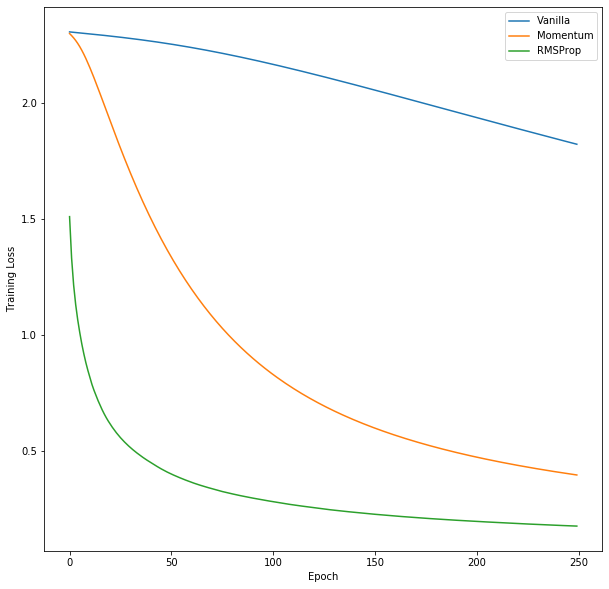

In [12]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [13]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""

beta1 = 0.9
beta2 = 0.99
epsilon = 0.00000000001

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

t = 1

# data for analysis
Adam_loss = []

"""
You probably need to initialize your variance and momentum here...
"""

m_w1 = np.zeros(W1.shape)
m_w2 = np.zeros(W2.shape)
m_b1 = np.zeros(b1.shape)
m_b2 = np.zeros(b2.shape)

v_w1 = np.zeros(W1.shape)
v_w2 = np.zeros(W2.shape)
v_b1 = np.zeros(b1.shape)
v_b2 = np.zeros(b2.shape)

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        
        # update momentum
        
        m_w1 = beta1*m_w1 + (1-beta1)*grad_W1
        m_w2 = beta1*m_w2 + (1-beta1)*grad_W2
        m_b1 = beta1*m_b1 + (1-beta1)*grad_b1
        m_b2 = beta1*m_b2 + (1-beta1)*grad_b2

        # update variance
        
        v_w1 = beta2*v_w1 + (1-beta2)*np.square(W1)
        v_w2 = beta2*v_w2 + (1-beta2)*np.square(W2)
        v_b1 = beta2*v_b1 + (1-beta2)*np.square(b1)
        v_b2 = beta2*v_b2 + (1-beta2)*np.square(b2)
        
        # bias correction
        
        m_hat_w1 = np.divide(m_w1, (1-beta1**t))
        m_hat_w2 = np.divide(m_w2, (1-beta1**t))
        m_hat_b1 = np.divide(m_b1, (1-beta1**t))
        m_hat_b2 = np.divide(m_b2, (1-beta1**t))
        
        v_hat_w1 = np.divide(v_w1, (1-beta2**t))
        v_hat_w2 = np.divide(v_w2, (1-beta2**t))
        v_hat_b1 = np.divide(v_b1, (1-beta2**t))
        v_hat_b2 = np.divide(v_b2, (1-beta2**t))
        
        
        # update weights
        W1 -= eta*np.divide(m_hat_w1, np.sqrt(v_hat_w1 + epsilon))
        W2 -= eta*np.divide(m_hat_w2, np.sqrt(v_hat_w2 + epsilon))
        b1 -= eta*np.divide(m_hat_b1, np.sqrt(v_hat_b1 + epsilon))
        b2 -= eta*np.divide(m_hat_b2, np.sqrt(v_hat_b2 + epsilon))
        
        t+= 1

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 1.559574 Accuracy 0.780286
Epoch 10 Loss 0.726290 Accuracy 0.904571
Epoch 20 Loss 0.549304 Accuracy 0.912000
Epoch 30 Loss 0.459075 Accuracy 0.914571
Epoch 40 Loss 0.402098 Accuracy 0.916286
Epoch 50 Loss 0.363746 Accuracy 0.917143
Epoch 60 Loss 0.335046 Accuracy 0.916857
Epoch 70 Loss 0.312549 Accuracy 0.918286
Epoch 80 Loss 0.292698 Accuracy 0.917714
Epoch 90 Loss 0.276665 Accuracy 0.918857
Epoch 100 Loss 0.263865 Accuracy 0.919714
Epoch 110 Loss 0.252963 Accuracy 0.920000
Epoch 120 Loss 0.243379 Accuracy 0.920000
Epoch 130 Loss 0.235651 Accuracy 0.920286
Epoch 140 Loss 0.228482 Accuracy 0.920000
Epoch 150 Loss 0.221481 Accuracy 0.921429
Epoch 160 Loss 0.215054 Accuracy 0.922571
Epoch 170 Loss 0.209287 Accuracy 0.923429
Epoch 180 Loss 0.204027 Accuracy 0.924857
Epoch 190 Loss 0.199112 Accuracy 0.924286
Epoch 200 Loss 0.194551 Accuracy 0.924857
Epoch 210 Loss 0.190319 Accuracy 0.925429
Epoch 220 Loss 0.186594 Accuracy 0.924571
Epoch 230 Loss 0.183282 Accuracy 0.925143
Epo

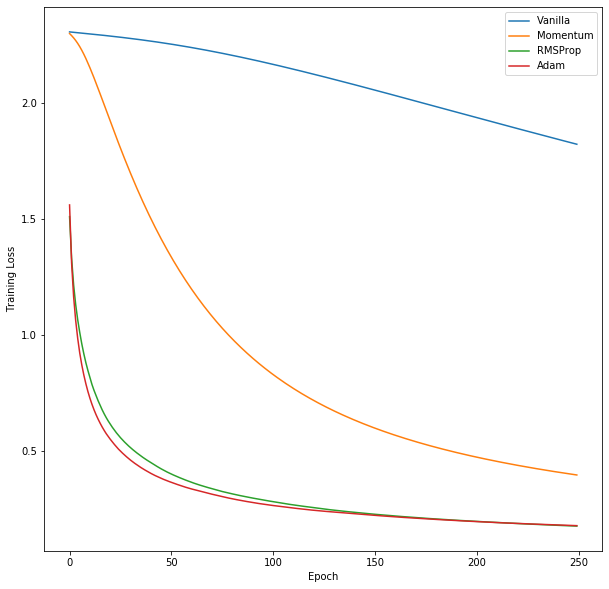

In [14]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()